# Analyse of oscilloscope and camera data

In [17]:
import matplotlib.pyplot as plt
import glob
import os
import time
import pandas as pd 
import matplotlib.dates as mdates

%pylab inline --no-import-all

file = "/storage/experiments/2021/0807_bourka_sobeslav"
file = "/storage/experiments/2021/0822_bourka_sobeslav_auto1/slavia/1629713811.182914.csv"


Populating the interactive namespace from numpy and matplotlib


In [3]:
df = pd.read_table(file, sep=',', header=0)

In [4]:
df['time']=df.index*8e-9 # fillin of correct sample time

In [5]:
df.set_index('time', inplace=True)
#df.drop(df.columns[2], inplace=True, axis=1)
#df.drop(df.columns[2], inplace=True, axis=1)
#df.drop(df.columns[2], inplace=True, axis=1)

## Save to HDF

In [6]:
cols_to_keep = ['CH1(V)', 'CH2(V)']
df.index = pd.to_datetime(df.index, unit='s')
df.loc[:, cols_to_keep].to_hdf(file+'.hdf','df', mode='w')

## Read data

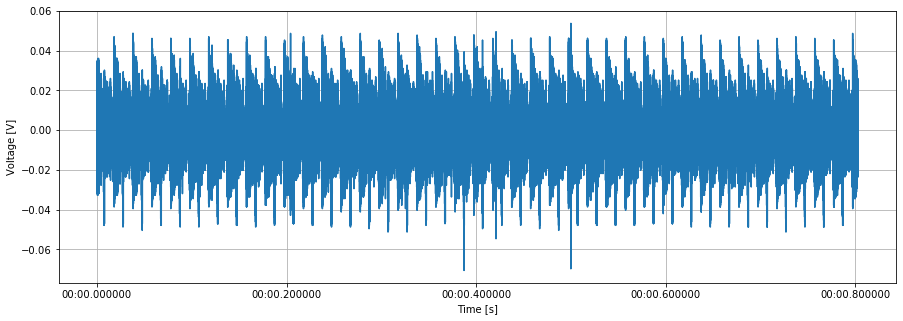

In [7]:
# Read oscilloscope data
df=pd.read_hdf(file+'.hdf')
plt.figure(figsize=(15,5))
plt.plot(df['CH2(V)'])
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()

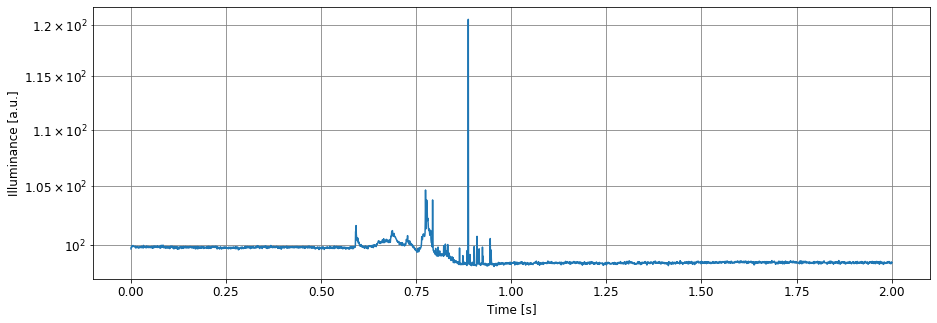

In [50]:
# Read illuminance data
f = "/storage/experiments/2021/0822_bourka_sobeslav_auto1/video/1629713811.182914.mp4.csv"
y = pd.read_csv(f)

plt.figure(figsize=(15,5))
plt.rc('font', size=12)    

#y['time'] = (y.index - 1613)*(1/1610)
y['time'] = (y.index)*(1/1610)

plt.plot(y['time'], y['0'])
plt.yscale('log')
plt.xlabel('Time [s]')
plt.ylabel('Illuminance [a.u.]')
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
#plt.xticks(np.arange(0, 4000, 100))


## Resample oscilloscope data

In [51]:
xx = df.resample('1us', closed='left').mean()

# Plot antenna and camera data together

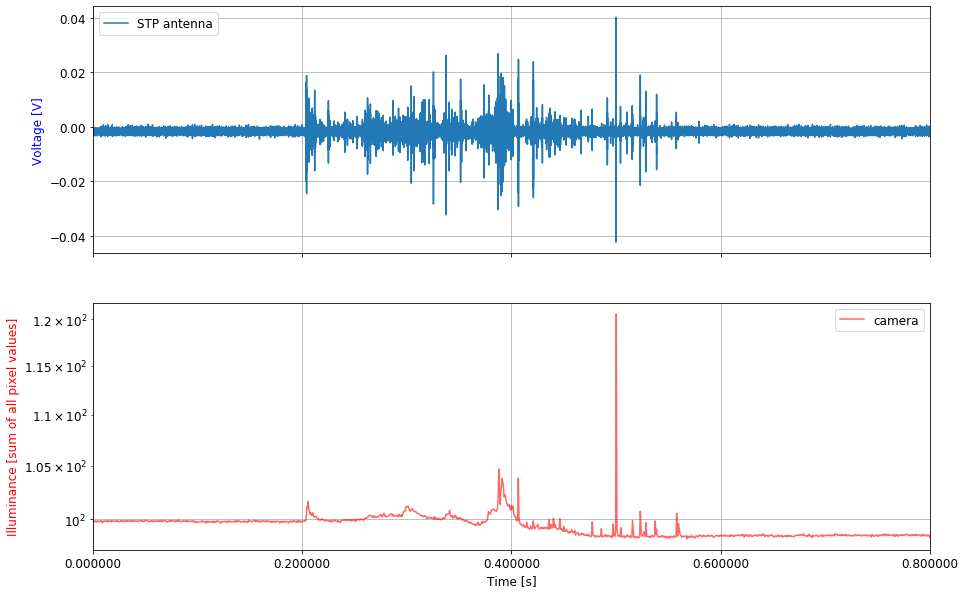

In [54]:
fig, (ax1,  ax2) = plt.subplots(figsize=(15, 10), nrows=2, sharex=True)

ax1.plot(xx['CH2(V)'], label='STP antenna', alpha=0.99)
#plt.xlabel('Time [s]')
ax1.set_ylabel('Voltage [V]', c='b')
ax1.grid()
ax1.legend(loc = "upper left")

ax1.set_xlim(pd.to_datetime(0, unit='s'),pd.to_datetime(0.8, unit='s'))

#y['time'] = pd.to_datetime((y.index - 1613)*(1/1612.38)+0.215, unit='s')
y['time'] = pd.to_datetime((y.index - 1613)*(1/1612.38)+0.615, unit='s')

ax2.plot(y['time'], y['0'], c='red', alpha=0.6, label='camera')
ax2.set_yscale('log')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Illuminance [sum of all pixel values]', c='r')
ax2.grid()
ax2.legend(loc = "upper right")
ax2.xaxis.set_major_formatter(mdates.DateFormatter('0.%f'))
#plt.ylim(90,10e2)

/nix/store/bd5a7gsg47qnkwywa7r5p7vnyyvpakya-python3-3.7.6-env/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


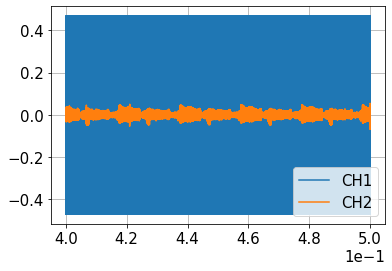

In [45]:
xx = df[0.4:0.5]
plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.plot(xx['CH1(V)'], label='CH1')
plt.plot(xx['CH2(V)'], label='CH2')
#plt.ylim(-0.1,0)
plt.legend()
plt.grid()

# Light curve with antenna

In [3]:
#f = "/storage/experiments/2021/0807_bourka_sobeslav" + "/video/1628431195.5110645.mp4.csv"
#df=pd.read_hdf(file+'/slavia/hdf/RigolDS0.csv.hdf')
#f = "/storage/experiments/2021/0725_bourka_ratmirov" + "/video/1627302288.9546976.mp4.csv"
#df=pd.read_hdf(file+'/slavia/hdf/RigolDS1.csv.hdf')
f = "/storage/experiments/2021/0822_bourka_sobeslav_auto1/video/1629713811.182914.mp4.csv"
df=pd.read_hdf(file+'.hdf')
#f = "/storage/experiments/2021/0725_bourka_ratmirov" + "/video/1627302184.9854863.mp4.csv"
#df=pd.read_hdf(file+'/slavia/hdf/RigolDS2.csv.hdf')
df['CH2(V)']

time
0.000000e+00   -0.001681
8.000000e-09   -0.001681
1.600000e-08   -0.001681
2.400000e-08   -0.000841
3.200000e-08   -0.000841
                  ...   
8.028160e-01   -0.000841
8.028160e-01   -0.000841
8.028160e-01   -0.001681
8.028160e-01   -0.001681
8.028160e-01   -0.001681
Name: CH2(V), Length: 100352000, dtype: float64

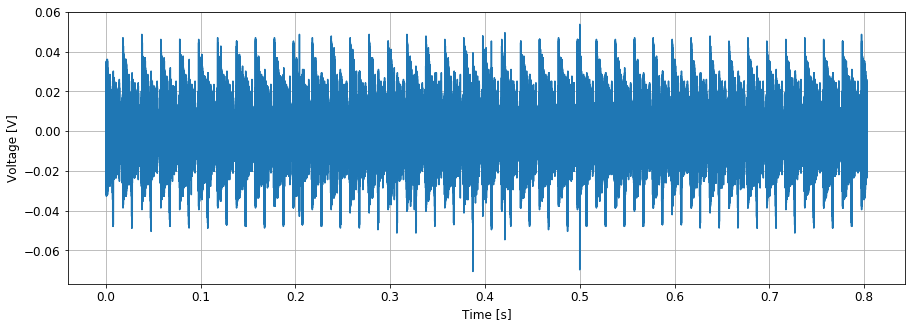

In [71]:
plt.figure(figsize=(15,5))
plt.plot(df['CH2(V)'])
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()

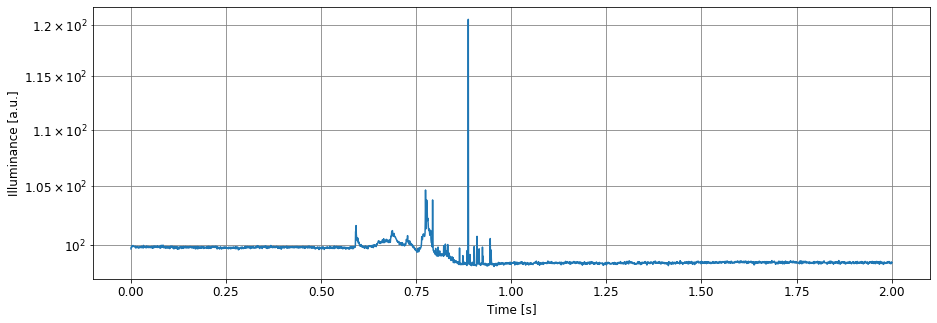

In [4]:
y = pd.read_csv(f)

plt.figure(figsize=(15,5))
plt.rc('font', size=12)    

#y['time'] = (y.index - 1613)*(1/1610)
y['time'] = (y.index)*(1/1610)

plt.plot(y['time'], y['0'])
plt.yscale('log')
plt.xlabel('Time [s]')
plt.ylabel('Illuminance [a.u.]')
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
#plt.xticks(np.arange(0, 4000, 100))


In [ ]:
df.index = pd.to_datetime(df.index, unit='s')

In [74]:
xx = df.resample('1us', closed='left').mean()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(xx['CH2(V)'], label='antenna', alpha=0.99)
#plt.plot(df['CH1(V)'], label='antenna')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()
plt.legend(loc = "upper left")

plt.xlim(pd.to_datetime(0, unit='s'),pd.to_datetime(0.8, unit='s'))

plt.twinx()

#y['time'] = pd.to_datetime((y.index - 1613)*(1/1612.38)+0.215, unit='s')
y['time'] = pd.to_datetime((y.index - 1613)*(1/1612.38)+0.615, unit='s')

plt.plot(y['time'], y['0'], c='red', alpha=0.6, label='camera')
plt.yscale('log')
plt.xlabel('Time [s]')
plt.ylabel('Illuminance [a.u.]')
plt.legend(loc = "upper right")
#plt.ylim(90,10e2)

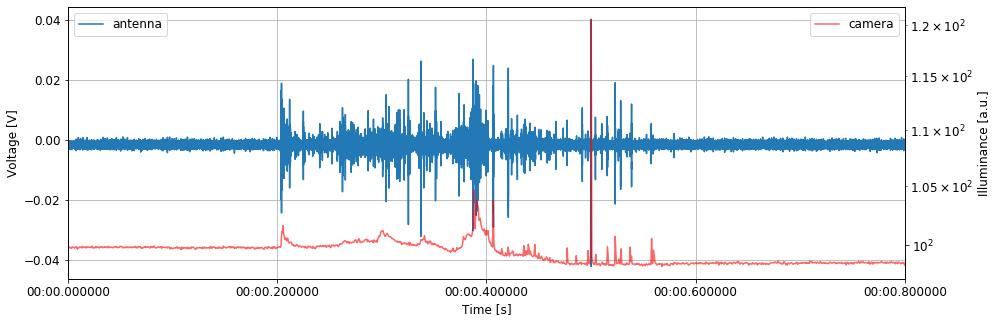

In [88]:
plt.figure(figsize=(15,5))
plt.plot(xx['CH2(V)'], label='antenna', alpha=0.99)
#plt.plot(df['CH1(V)'], label='antenna')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()
plt.legend(loc = "upper left")

plt.xlim(pd.to_datetime(0, unit='s'),pd.to_datetime(0.8, unit='s'))

plt.twinx()

#y['time'] = pd.to_datetime((y.index - 1613)*(1/1612.38)+0.215, unit='s')
y['time'] = pd.to_datetime((y.index - 1613)*(1/1612.38)+0.615, unit='s')

plt.plot(y['time'], y['0'], c='red', alpha=0.6, label='camera')
plt.yscale('log')
plt.xlabel('Time [s]')
plt.ylabel('Illuminance [a.u.]')
plt.legend(loc = "upper right")
#plt.ylim(90,10e2)

Plotting microsecond time intervals is not well supported. Please see the MicrosecondLocator documentation for details.
Plotting microsecond time intervals is not well supported. Please see the MicrosecondLocator documentation for details.
Plotting microsecond time intervals is not well supported. Please see the MicrosecondLocator documentation for details.
Plotting microsecond time intervals is not well supported. Please see the MicrosecondLocator documentation for details.
Plotting microsecond time intervals is not well supported. Please see the MicrosecondLocator documentation for details.
Plotting microsecond time intervals is not well supported. Please see the MicrosecondLocator documentation for details.
Plotting microsecond time intervals is not well supported. Please see the MicrosecondLocator documentation for details.
Plotting microsecond time intervals is not well supported. Please see the MicrosecondLocator documentation for details.
Plotting microsecond time intervals is n

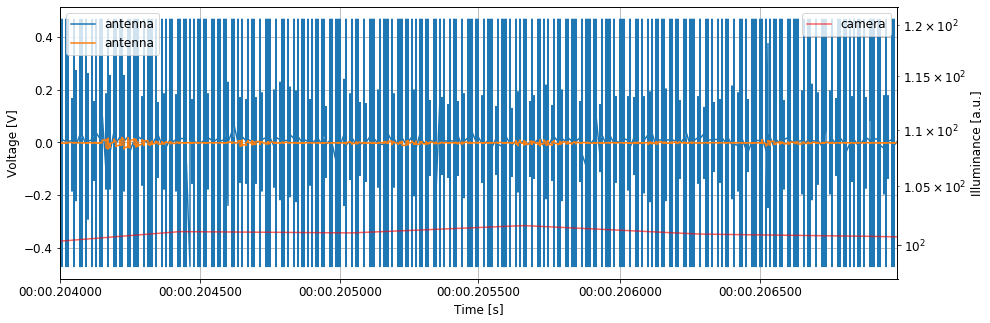

In [101]:
plt.figure(figsize=(15,5))
plt.plot(df['CH1(V)'], label='antenna')
plt.plot(xx['CH2(V)'], label='antenna', alpha=0.99)
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()
plt.legend(loc = "upper left")

plt.xlim(pd.to_datetime(0.204, unit='s'),pd.to_datetime(0.207, unit='s'))

plt.twinx()

#y['time'] = pd.to_datetime((y.index - 1613)*(1/1612.38)+0.215, unit='s')
y['time'] = pd.to_datetime((y.index - 1613)*(1/1612.38)+0.615, unit='s')

plt.plot(y['time'], y['0'], c='red', alpha=0.6, label='camera')
plt.yscale('log')
plt.xlabel('Time [s]')
plt.ylabel('Illuminance [a.u.]')
plt.legend(loc = "upper right")
#plt.ylim(90,10e2)

In [ ]:
plt.figure(figsize=(15,5))
#df.index = pd.to_datetime(df.index, unit='s')
plt.plot(df['CH2(V)'], label='antenna')

#plt.plot(df['CH2(V)'].resample('1ms').mean(), label='antenna filt.')
#plt.plot(df['CH1(V)'], label='antenna')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()
plt.legend(loc = "upper left")

plt.twinx()

y['time'] = (y.index - 1613)*(1/1612.38)+0.194

plt.plot(y['time'], y['0'], c='red', alpha=0.5, label='camera')
plt.yscale('log')
plt.xlabel('Time [s]')
plt.ylabel('Illuminance [a.u.]')
plt.legend(loc = "upper right")


In [104]:
df = df.loc[-0.15:0,'CH2(V)'].copy()

In [18]:
df=df.reset_index()

In [141]:
first = df['CH2(V)'].idxmin()
second = df.loc[first+10:,'CH2(V)'].idxmin()
second = df.loc[first+10:first+6000,'CH2(V)'].idxmin()
period = second - first

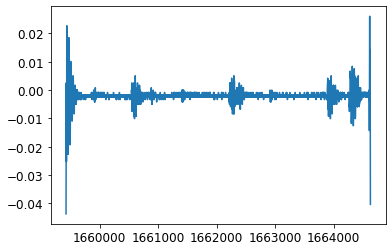

In [142]:
plt.plot(df.loc[first:second,'CH2(V)'])

In [147]:
xx = df['CH2(V)'].to_numpy()
periods = round(len(xx)/period)-1
xx = xx[:period*periods]
periodic = xx.reshape(periods, period)
avg_signal = periodic.mean(axis=0)

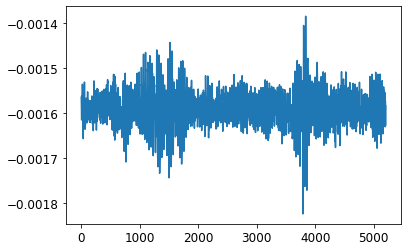

In [148]:
plt.plot(avg_signal)

In [55]:
df.index = pd.to_datetime(df.index, unit='s')

In [56]:
xx = df.resample('1us', closed='left').mean()

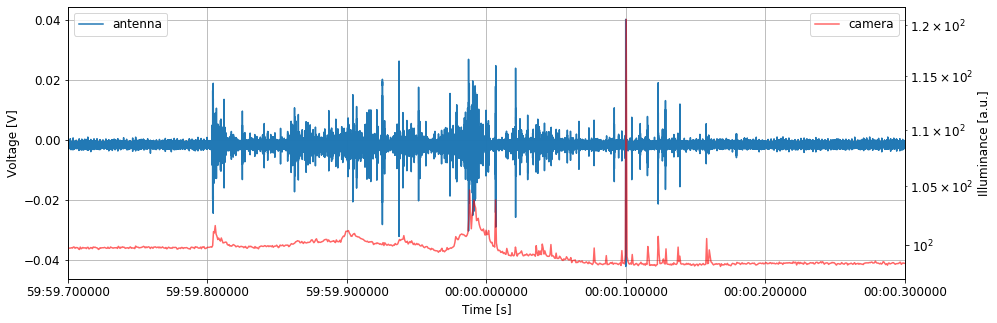

In [69]:
plt.figure(figsize=(15,5))
plt.plot(xx['CH2(V)'], label='antenna', alpha=0.99)
#plt.plot(df['CH1(V)'], label='antenna')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()
plt.legend(loc = "upper left")

plt.xlim(pd.to_datetime(-0.3, unit='s'),pd.to_datetime(0.3, unit='s'))

plt.twinx()

y['time'] = pd.to_datetime((y.index - 1613)*(1/1612.38)+0.215, unit='s')

plt.plot(y['time'], y['0'], c='red', alpha=0.6, label='camera')
plt.yscale('log')
plt.xlabel('Time [s]')
plt.ylabel('Illuminance [a.u.]')
plt.legend(loc = "upper right")
#plt.ylim(90,10e2)

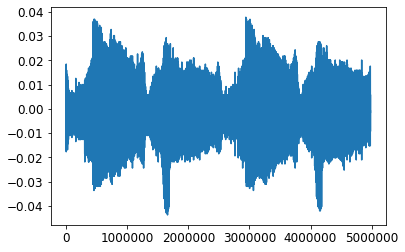

In [97]:
df.loc[:2*period,'CH2(V)'].plot()